In [1]:
import os
import pandas as pd
import anndata
import numpy as np

import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from load_st_data import load_mHypothalamus
from evaluate import evaluate_clustering

import scanpy as sc
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is dep

In [2]:
import SEDR

In [3]:
random_seed = 2023
SEDR.fix_seed(random_seed)

In [4]:
device = 'cuda:5' if torch.cuda.is_available() else 'cpu'

data_root = Path('../data/mHypothalamus')

# sample name
sample_name = '-0.04'
device

'cuda:5'

In [5]:
adata = load_mHypothalamus(data_root, section_id=sample_name)

In [6]:
adata

AnnData object with n_obs × n_vars = 5488 × 155
    obs: 'psuedo_barcodes', 'x', 'y', 'cell_class', 'Neuron_cluster_ID', 'layer_guess'
    var: 'Unnamed: 0'
    obsm: 'spatial'

In [7]:
pca_n_comps = min(200, len(adata.var.index) - 1)


In [8]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True, inplace=False)['X']
sc.pp.scale(adata)
# sc.pp.pca(adata, n_comps=pca_n_comps)
from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=pca_n_comps, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [9]:
adata.shape

(5488, 155)

In [10]:
adata

AnnData object with n_obs × n_vars = 5488 × 155
    obs: 'psuedo_barcodes', 'x', 'y', 'cell_class', 'Neuron_cluster_ID', 'layer_guess'
    var: 'Unnamed: 0', 'n_cells', 'mean', 'std'
    obsm: 'spatial', 'X_pca'

In [11]:
graph_dict = SEDR.graph_construction(adata, 12)
print(graph_dict)

{'adj_norm': tensor(indices=tensor([[   0,    0,    0,  ..., 5487, 5487, 5487],
                       [   0,    4,    5,  ..., 5085, 5482, 5487]]),
       values=tensor([0.0769, 0.0769, 0.0741,  ..., 0.0668, 0.0741, 0.0714]),
       size=(5488, 5488), nnz=78978, layout=torch.sparse_coo), 'adj_label': tensor(indices=tensor([[   0,    0,    0,  ..., 5487, 5487, 5487],
                       [   0,    4,    5,  ..., 5085, 5482, 5487]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(5488, 5488), nnz=78978, dtype=torch.float64,
       layout=torch.sparse_coo), 'norm_value': 0.5013145837670726}


In [12]:
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device=device)
using_dec = True
if using_dec:
    sedr_net.train_with_dec(N=1)
else:
    sedr_net.train_without_dec(N=1)
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

100%|██████████| 200/200 [00:01<00:00, 105.59it/s]


In [13]:
from res_search import search_resolution

In [14]:
n_clusters = 8
# SEDR.mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR')
sc.pp.neighbors(adata ,n_neighbors=20)
eval_res = search_resolution(adata, n_clusters, res_start=0.1, res_end=1, res_step=0.02)
sc.tl.leiden(adata, key_added='SEDR_leiden', resolution=eval_res)
print('Finish!')

Resolution: 0.17999999999999997
Finish!


In [15]:
adata

AnnData object with n_obs × n_vars = 5488 × 155
    obs: 'psuedo_barcodes', 'x', 'y', 'cell_class', 'Neuron_cluster_ID', 'layer_guess', 'leiden', 'SEDR_leiden'
    var: 'Unnamed: 0', 'n_cells', 'mean', 'std'
    uns: 'neighbors', 'leiden', 'SEDR_leiden'
    obsm: 'spatial', 'X_pca', 'SEDR'
    obsp: 'distances', 'connectivities'

In [16]:
df_meta = adata.obs

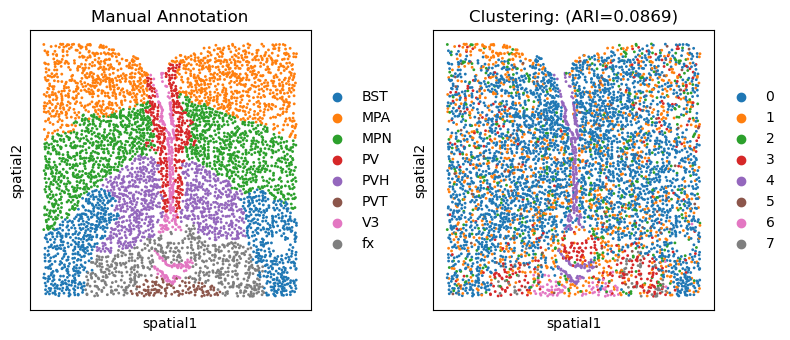

In [24]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['layer_guess'], sub_adata.obs['SEDR_leiden'])

fig, axes = plt.subplots(1,2,figsize=(4*2, 4))
sc.pl.spatial(adata, color='layer_guess', ax=axes[0], show=False, spot_size=20)
sc.pl.spatial(adata, color='SEDR_leiden', ax=axes[1], show=False, spot_size=20)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering: (ARI=%.4f)' % ARI)
plt.tight_layout()
plt.show()

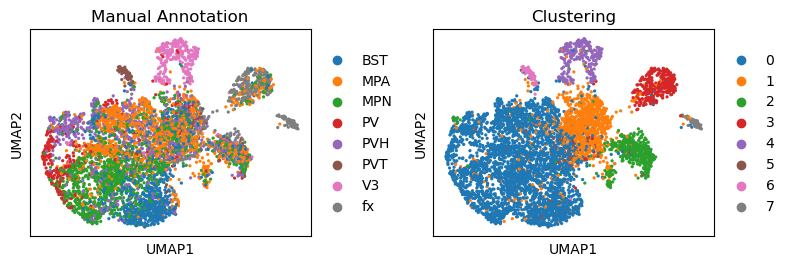

In [26]:
sc.pp.neighbors(adata, use_rep='SEDR', metric='cosine')
sc.tl.umap(adata)

fig, axes = plt.subplots(1,2,figsize=(4*2, 3))
sc.pl.umap(adata, color='layer_guess', ax=axes[0], show=False)
sc.pl.umap(adata, color='SEDR_leiden', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering')

for ax in axes:
    ax.set_aspect(1)
    
plt.tight_layout()
plt.show()